In [1]:
#!pip install autogluon --user
#!pip install sweetviz --user
#!pip install featuretools --user

****Traditional Approach (Manual EDA and Modeling)****

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
pass_id = df_test["PassengerId"]

def preprocess(df):
    # drop unnecessary columns
    df = df.drop(["Ticket", "Cabin", "Name", "PassengerId"], axis=1)
    
    # fill missing vals for numeric columns
    columns = ["SibSp", "Parch", "Fare", "Age"]
    for col in columns:
        df[col] = df[col].fillna(df[col].mean())
    
    df["Embarked"] = df["Embarked"].fillna("X")
    
    return df

df_train = preprocess(df_train)
df_test = preprocess(df_test)

C:\Users\boman\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

columns = ["Sex", "Embarked"]
for col in columns:
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
    print(le.classes_)

df_train.head()

['female' 'male']
['C' 'Q' 'S' 'X']


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = df_train["Survived"]
x = df_train.drop("Survived", axis = 1)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)

lr = LogisticRegression(max_iter = 2000, random_state = 42).fit(x_train, y_train)

rf = RandomForestClassifier(n_estimators = 100, max_depth=None, random_state = 42).fit(x_train, y_train)

In [6]:
from sklearn.metrics import accuracy_score
lr_preds = lr.predict(x_val)
rf_preds = rf.predict(x_val)

lr_acc = accuracy_score(y_val, lr_preds)
rf_acc = accuracy_score(y_val, rf_preds)
print("LR: ", lr_acc)
print("RF: ", rf_acc)

LR:  0.8100558659217877
RF:  0.8156424581005587


In [7]:
sub_preds = rf.predict(df_test)

****AutoML Approach****

                                             |          | [  0%]   00:00 -> (? left)


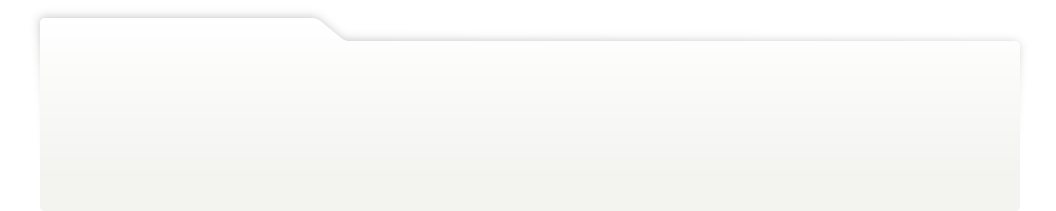
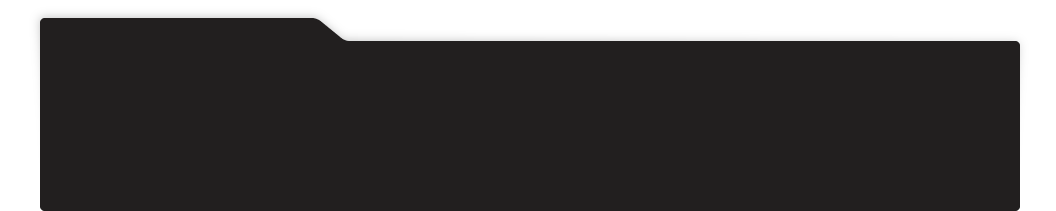
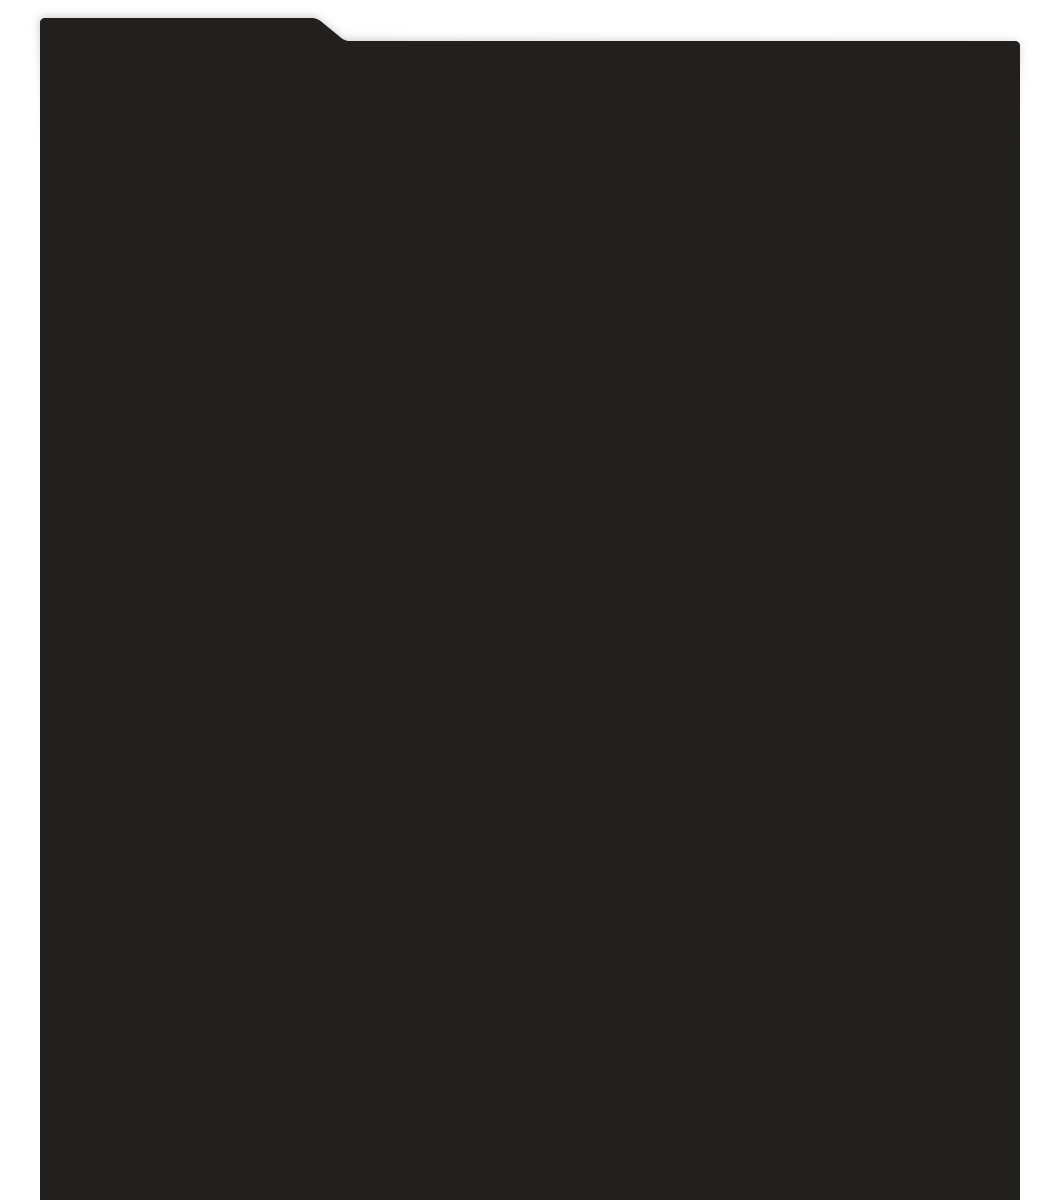
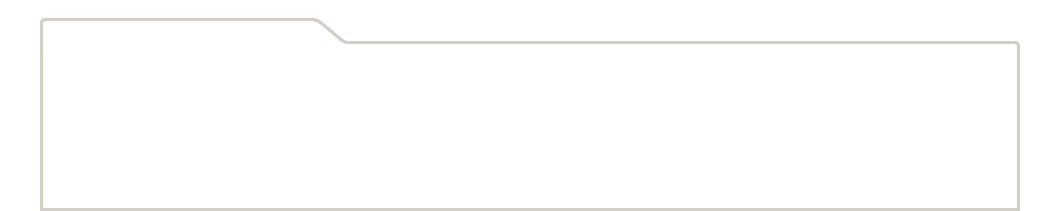
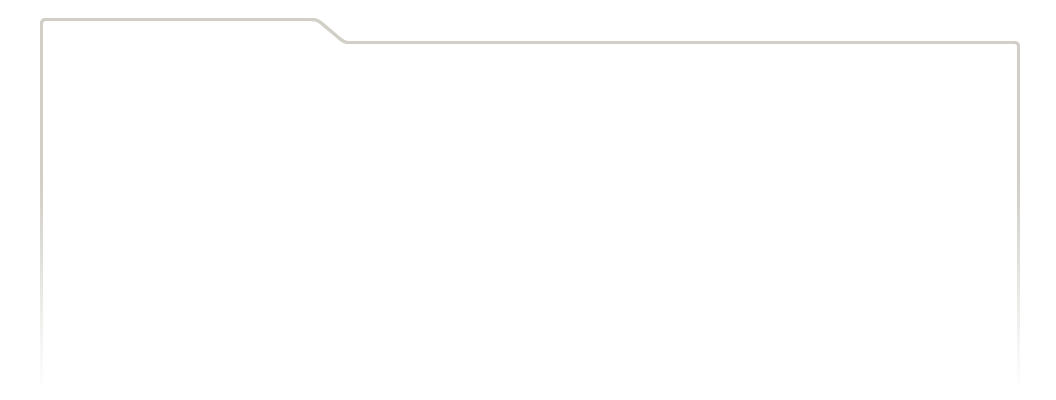
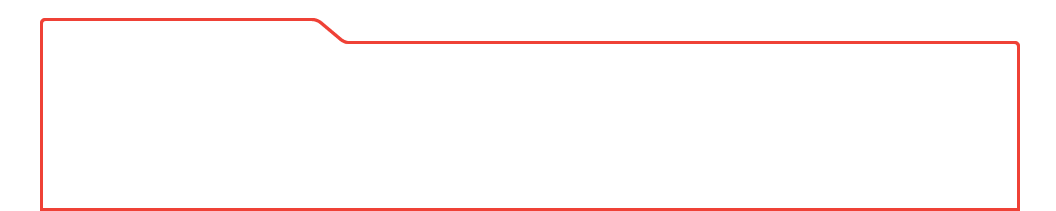
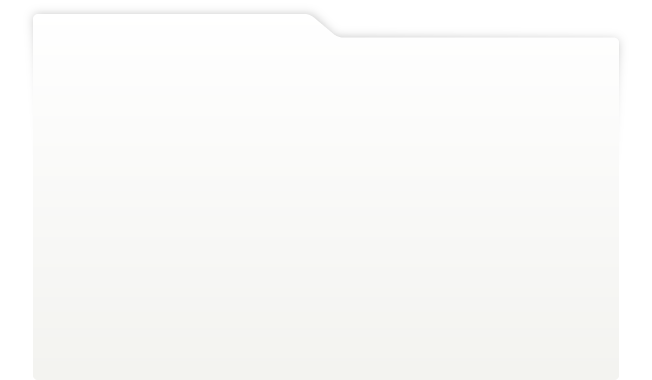
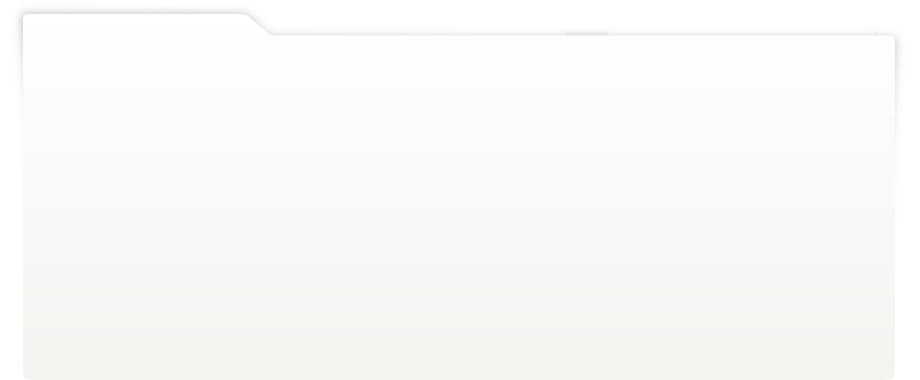
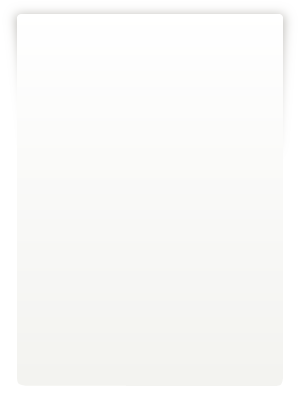
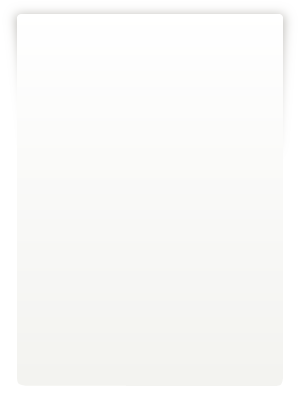
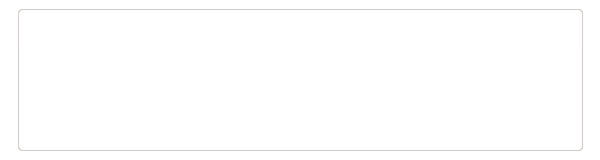
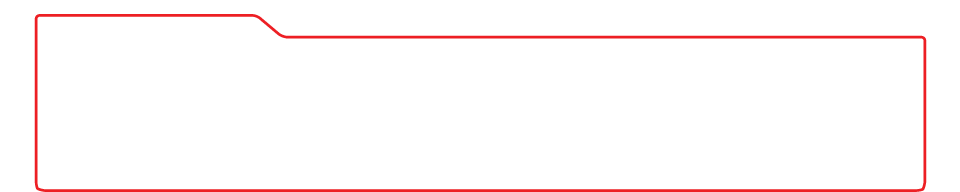
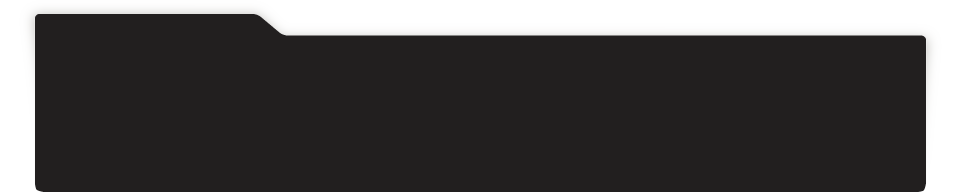
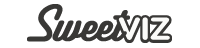
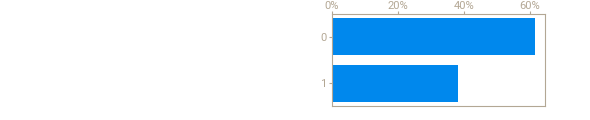
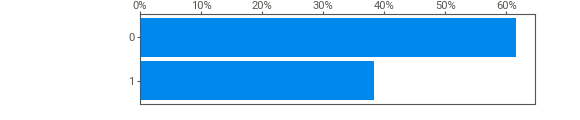
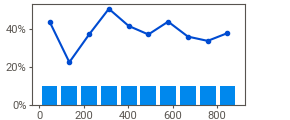
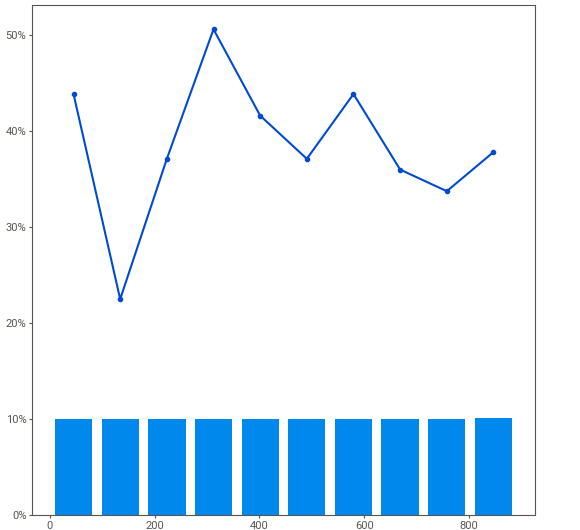
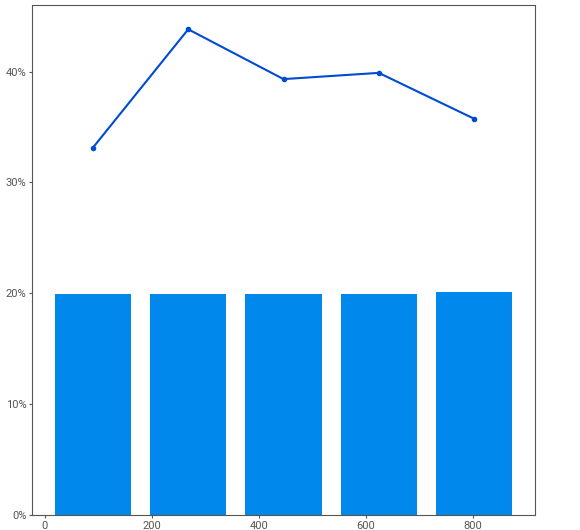
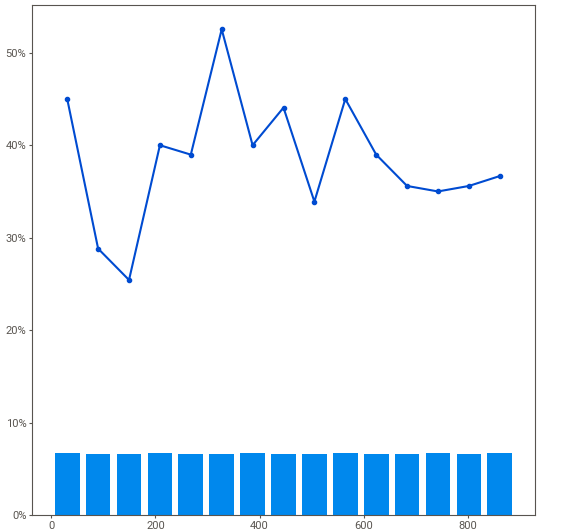
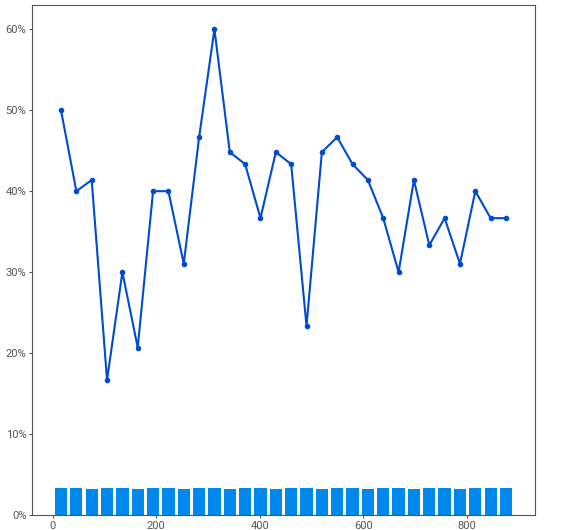
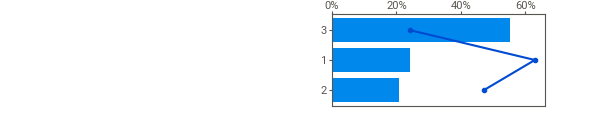
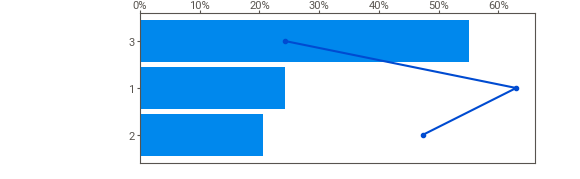
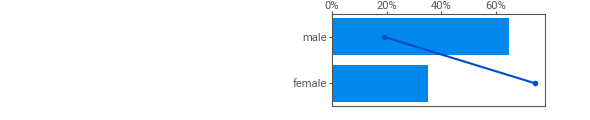
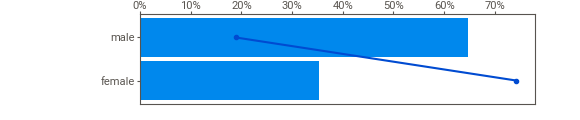
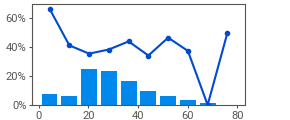
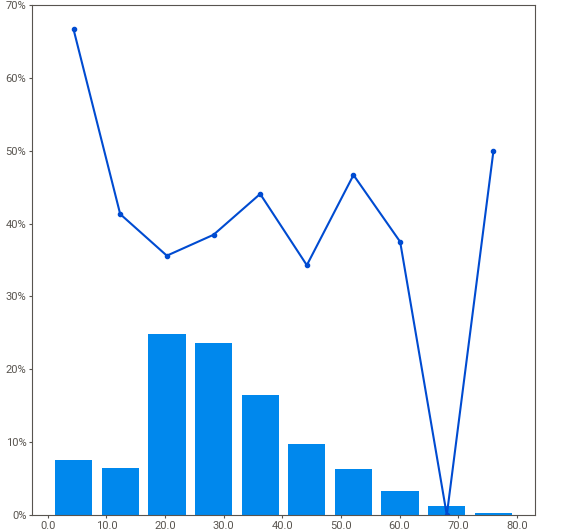
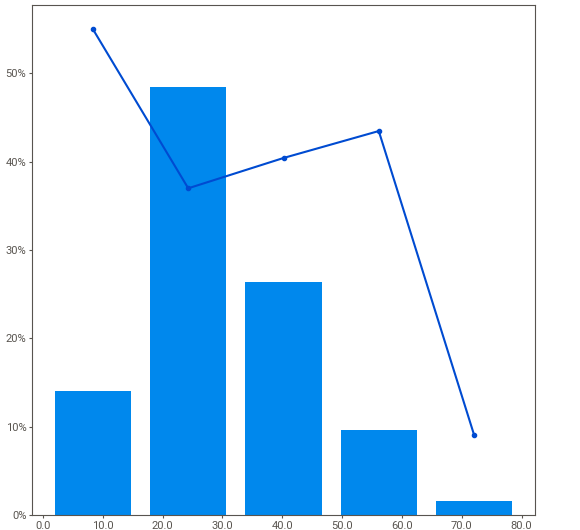
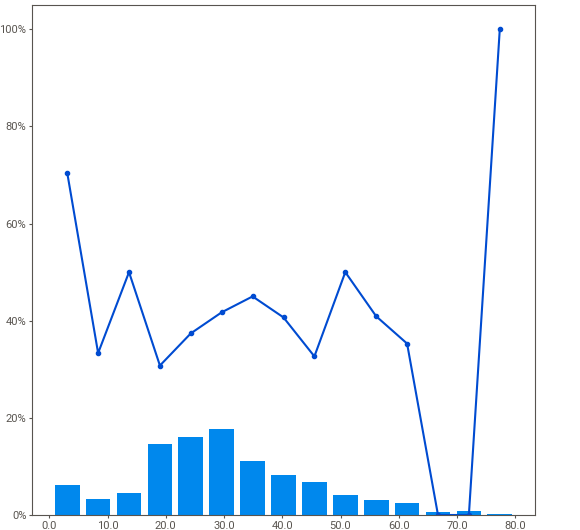
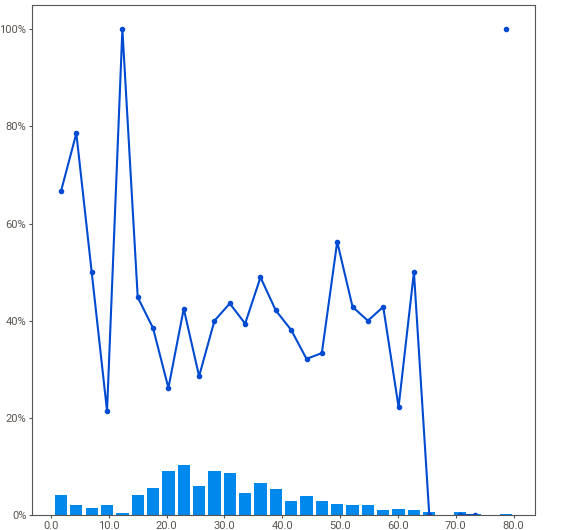
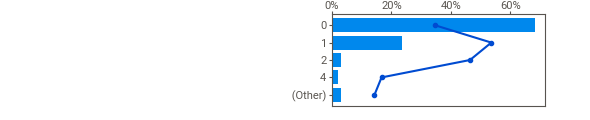
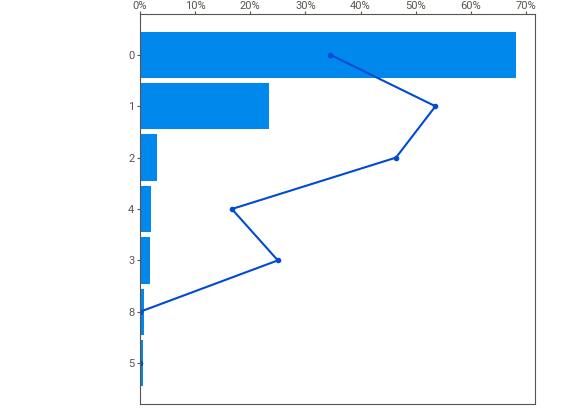
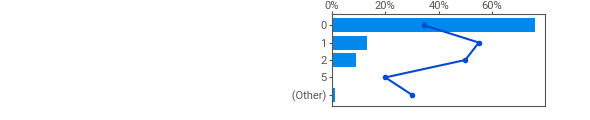
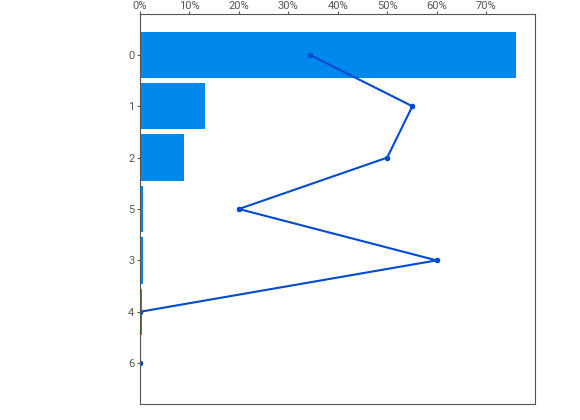
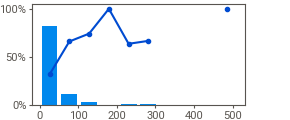
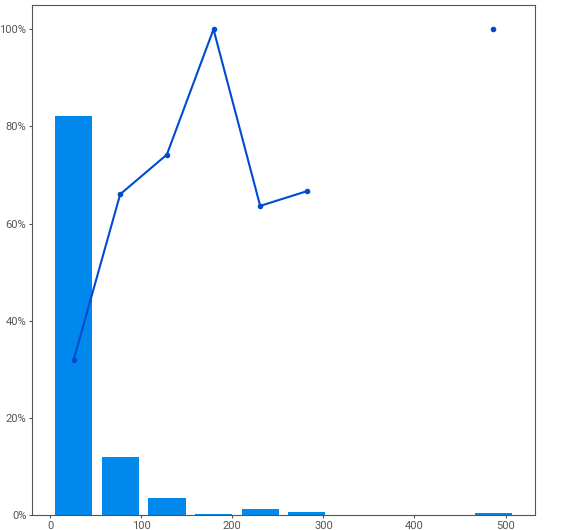
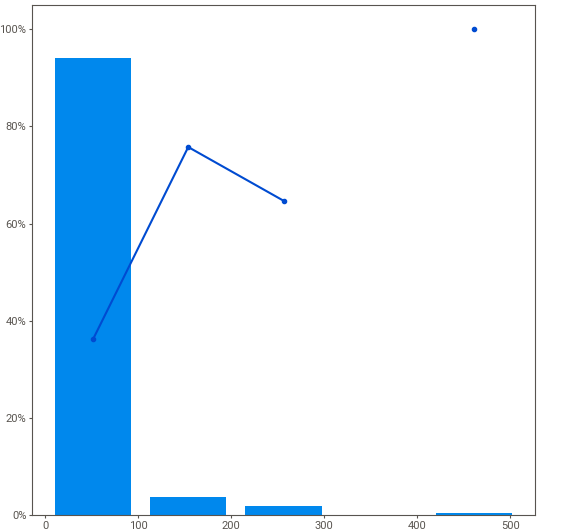
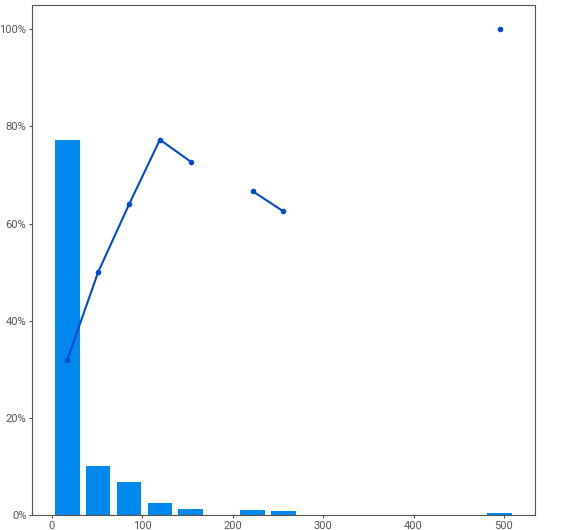
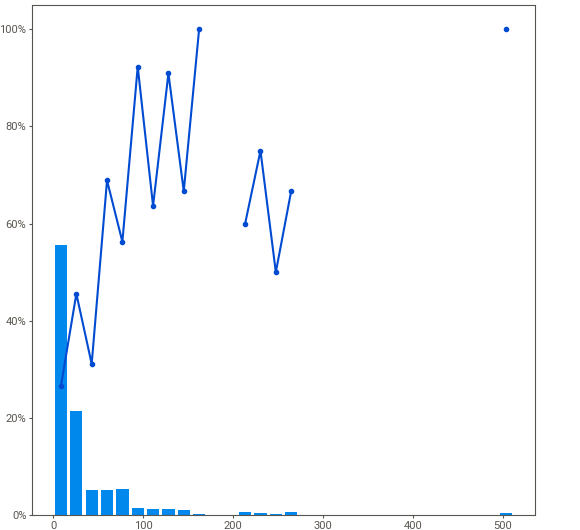
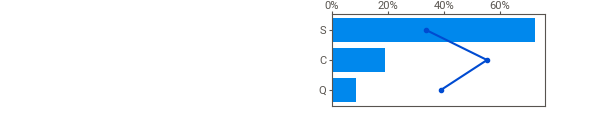
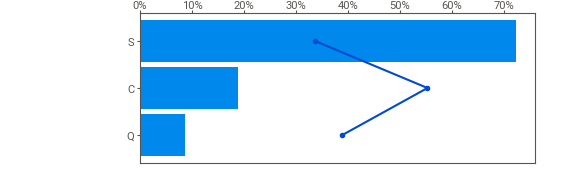
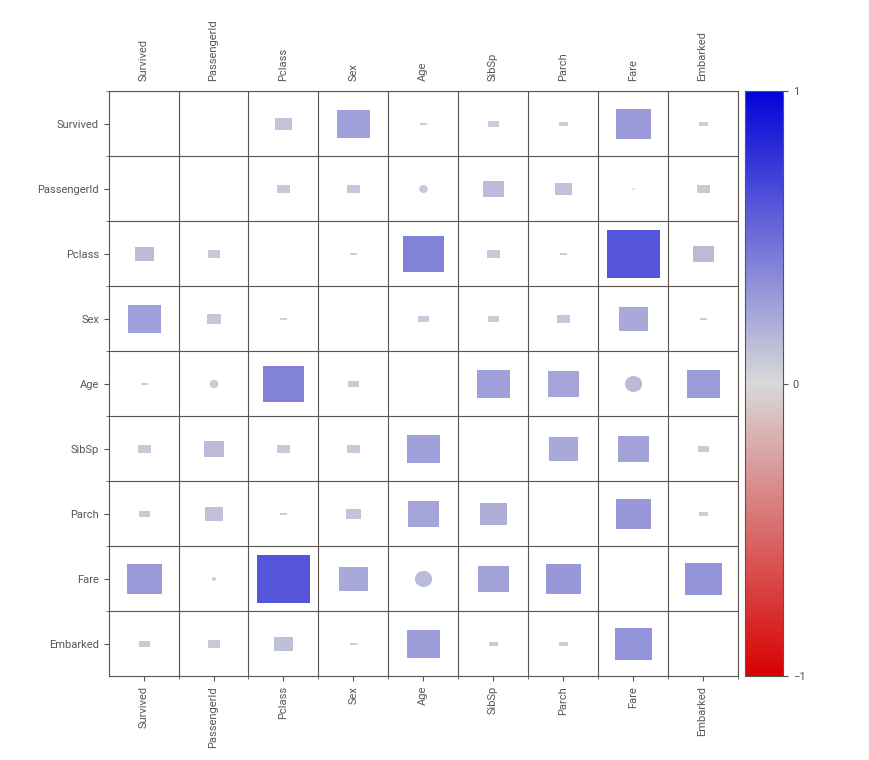
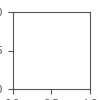

Sweetviz report generated: train_eda


In [8]:
from autogluon.tabular import TabularPredictor
import sweetviz as sv
import featuretools as ft
import pandas as pd

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
pass_id = df_test["PassengerId"]

# create a copy of test data with a dummy target column
df_test_dummy = df_test.copy()
df_test_dummy['Survived'] = 0  # Add dummy values

# generate Sweetviz report
train_report = sv.analyze(df_train, target_feat='Survived')
train_report.show_notebook()
print("Sweetviz report generated: train_eda")

In [9]:
# define the entity set for train
es_train = ft.EntitySet(id="titanic_train")
es_train = es_train.add_dataframe(
    dataframe_name="data",
    dataframe=df_train,
    index="PassengerId"
)

# generate features for training dataset
feature_matrix_train, feature_defs = ft.dfs(
    entityset=es_train,
    target_dataframe_name="data",
    max_depth=2,
    ignore_columns={'data': ['Survived']}  # Fix: Specify dataframe name with column
)

# create entity set for test with dummy target
es_test = ft.EntitySet(id="titanic_test")
es_test = es_test.add_dataframe(
    dataframe_name="data",
    dataframe=df_test_dummy,  # Use the dummy dataset
    index="PassengerId"
)

# apply feature definitions to test set
feature_matrix_test = ft.calculate_feature_matrix(
    features=feature_defs,
    entityset=es_test
)

C:\Users\boman\AppData\Roaming\Python\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\boman\AppData\Roaming\Python\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\boman\AppData\Roaming\Python\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
C:\Users\boman\AppData\Roaming\Python\Python311\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not

In [10]:
# remove columns related to dummy target from test features
feature_matrix_test = feature_matrix_test.drop(columns=[col for col in feature_matrix_test.columns if 'Survived' in col])

# merge features back into original datasets
df_train_engineered = df_train.merge(feature_matrix_train, left_on="PassengerId", right_index=True)
df_test_engineered = df_test.merge(feature_matrix_test, left_on="PassengerId", right_index=True)

print("Feature engineering complete. Updated dataset shapes:")
print("Train dataset shape:", df_train_engineered.shape)
print("Test dataset shape:", df_test_engineered.shape)

Feature engineering complete. Updated dataset shapes:
Train dataset shape: (891, 19)
Test dataset shape: (418, 18)


In [11]:
# train model
label = "Survived"
predictor = TabularPredictor(label=label, problem_type="binary").fit(
    train_data=df_train_engineered,
    time_limit=600
)

# leaderboard
leaderboard = predictor.leaderboard(silent=True)
print("\nModel Leaderboard:")
print(leaderboard)

# predict
predictions = predictor.predict(df_test_engineered)

No path specified. Models will be saved in: "AutogluonModels\ag-20250121_023743"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
Memory Avail:       7.14 GB / 15.92 GB (44.9%)
Disk Space Avail:   202.90 GB / 465.09 GB (43.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         

	0.8212	 = Validation score   (accuracy)
	3.86s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 579.24s of the 579.24s of remaining time.
	0.8156	 = Validation score   (accuracy)
	0.74s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 578.47s of remaining time.
	Ensemble Weights: {'CatBoost': 0.667, 'NeuralNetFastAI': 0.333}
	0.838	 = Validation score   (accuracy)
	0.08s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 21.64s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 13765.9 rows/s (179 batch size)
Disabling decision threshold calibration for metric `accuracy` due to having fewer than 10000 rows of validation data for calibration, to avoid overfitting (179 rows).
	`accuracy` is generally not improved through threshold calibration. Force calibration via specifying `calibrate


Model Leaderboard:
                  model  score_val eval_metric  pred_time_val  fit_time  \
0   WeightedEnsemble_L2   0.837989    accuracy       0.013003  9.502854   
1              CatBoost   0.832402    accuracy       0.003001  8.524634   
2              LightGBM   0.821229    accuracy       0.004002  0.308974   
3       NeuralNetFastAI   0.821229    accuracy       0.009002  0.898201   
4        NeuralNetTorch   0.821229    accuracy       0.010002  3.861916   
5         LightGBMLarge   0.815642    accuracy       0.005001  0.743166   
6               XGBoost   0.815642    accuracy       0.005001  0.377084   
7        ExtraTreesEntr   0.815642    accuracy       0.035008  0.479106   
8      RandomForestGini   0.815642    accuracy       0.036007  0.513944   
9      RandomForestEntr   0.815642    accuracy       0.037009  0.497459   
10       ExtraTreesGini   0.810056    accuracy       0.036008  0.495111   
11           LightGBMXT   0.804469    accuracy       0.004002  1.148256   
12   

In [12]:
# submission file
submission = pd.DataFrame({"PassengerId": pass_id, "Survived": predictions})
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv
